#Implementation of BERT for Humour Detection

## Introduction
Whether it's a clever pun that tickles your funny bone, or a hilarious anecdote that leaves you in stitches, humour is the spice that adds flavour to our lives. Within the vast expanses of datasets available on Kaggle, there lies a collection of 200k texts classified as humorous and serious. We utilized this dataset to train a BERT model capable of classifying text into its respective categories (humorous or serious). Bidirectional Encoder Representations from Transformers (BERT) is a natural language processing (NLP) model that not only comprehends words but also delves into the context and meaning of text (Devlin, Chang, Lee, & Toutanova, 2019). What distinguishes BERT is its bidirectional approach to language understanding, enabling it to consider the full context of a word by examining both left and right in a sentence. This contextual comprehension makes BERT particularly adept at tasks like sentiment analysis, question answering, and, of course, humour detection.

## Installing libraries

In [30]:
# import clear out to clear output during library installation
from IPython.display import clear_output

In [31]:
!pip install --upgrade transformers
!pip install tf-keras

# Set environment variables if necessary for legacy compatibility in TensorFlow
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [32]:
# install transformers
!pip install tensorflow transformers

In [33]:
# install keras tuner
!pip install keras-tuner

In [34]:
# import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import transformers
from keras_tuner.tuners import RandomSearch
from IPython.display import display, clear_output
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from keras_tuner import HyperParameters

# pandas settings to view all rows and columns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Mounting google drive and loading dataset

In [35]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')
path_to_folder = "Colab Notebooks"
%cd /content/drive/My\ Drive/{path_to_folder}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks


In [36]:
# Load CSV data into a Pandas DataFrame
df = pd.read_csv('humor_dataset.csv')

In [37]:
#displaying first 5 rows of the dataset
df.head(5)

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False


In [38]:
texts = df['text'].to_list()
labels = df['humor'].to_list()

## Exploratory data analysis (EDA)

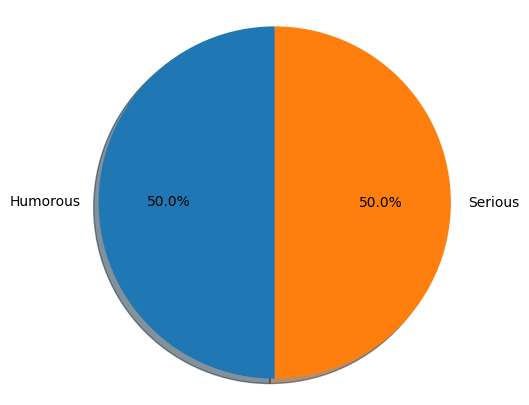

In [39]:
# Pie chart for humor distribution

fig = plt.figure(figsize=(5, 5))
labels_pie = 'Humorous', 'Serious'
sizes = [sum(labels), len(labels) - sum(labels)]

plt.pie(sizes, labels=labels_pie, autopct='%1.1f%%',
        shadow=True, startangle=90)

plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

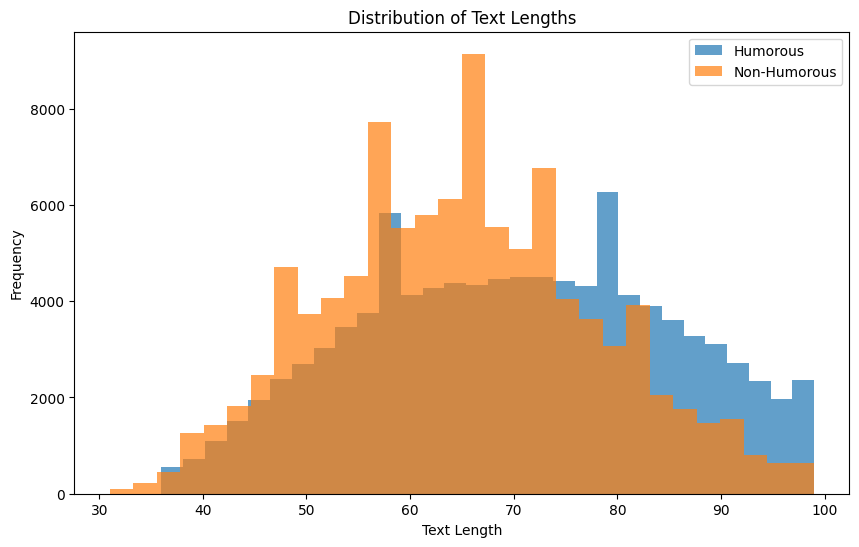

In [40]:
# Histogram for text length distribution

plt.figure(figsize=(10, 6))
plt.hist(df[df['humor'] == True]['text'].str.len(), bins=30, alpha=0.7, label='Humorous')
plt.hist(df[df['humor'] == False]['text'].str.len(), bins=30, alpha=0.7, label='Non-Humorous')
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.title("Distribution of Text Lengths")
plt.legend()
plt.show()

In [41]:
# Split the DataFrame into training, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=123)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=123)

In [42]:
# check example of humorous quotes in training dataset
df_humor = train_df[train_df['humor'] == 1]
print('Humorous quote')

# Sample 5 random rows and print out the 'humor' column
for _, row in df_humor.sample(5).iterrows():
    print(row['text'])
    print(' ')

Humorous quote
What was the name of the operation to catch juaquin guzman? el trapo.
 
Him: your so funny, smart & beautiful how are you still single me: *you're
 
What did cinderella say when she got to the ball? *gagging*
 
If you get a boner at a funeral is it still called mourning wood?
 
Q: why did the canadian cross the road? a: he saw some american do it on tv.
 


In [43]:
# check example of non-humorous quotes in training dataset
df_serious = train_df[train_df['humor'] == 0]
print('Non-humorous quote')

# Sample 5 random rows and print out the 'humor' column
for _, row in df_serious.sample(5).iterrows():
    print(row['text'])
    print(' ')


Non-humorous quote
Rihanna wore a fur coat instead of a shirt, because of course
 
'trump alarm' app will remind you to vote in the most irritating way
 
I won't be coming home for christmas: the christmas experience in prison
 
The one thing missing on your post-grad checklist: obamacare
 
Huffpost editors craft new editor's notes in the event that trump wins
 


## Preprocessing dataset

In [44]:
def preprocess(data):
    """
    Preprocess function to prepare the data for training.

    Args:
    - data: DataFrame containing text and label columns

    Returns:
    - texts: List of text data
    - labels: List of label data
    """
    texts = data['text'].tolist() # convert text to list
    labels = data['humor'].tolist() # get labels
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)

    dataset = tf.data.Dataset.from_tensor_slices((
    dict(encodings),
    labels
    ))

    return dataset

In [45]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [46]:
# apply preprocess function to train_df
train_dataset = preprocess(train_df)

# apply preprocess function to val_df
val_dataset = preprocess(val_df)

# appply preprocess function to test_df
test_dataset = preprocess(test_df)

## Training and fine tuning the model

In [47]:
# Function to build and compile the BERT model with tunable hyperparameters

def build_model(hp):
    bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    optimizer = tf.keras.optimizers.get({
        'class_name': hp.Choice('optimizer', ['Adam', 'SGD', 'RMSprop']),
        'config': {'learning_rate': hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log')}
    })
    bert_model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                       metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])
    return bert_model

# Initialize HyperParameters
hp = HyperParameters()
hp.Choice('optimizer', ['Adam', 'SGD', 'RMSprop'])
hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log')


1e-05

In [48]:
# Set up and execute hyperparameter tuning

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='bert_tuning',
    project_name='humor_classification'
)

tuner.search(train_dataset.batch(14), validation_data=val_dataset.batch(14), epochs=2)

Reloading Tuner from bert_tuning/humor_classification/tuner0.json


In [49]:
tuner.results_summary()

Results summary
Results in bert_tuning/humor_classification
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
optimizer: RMSprop
learning_rate: 1.0499426807036378e-05
Score: 0.9866999983787537

Trial 4 summary
Hyperparameters:
optimizer: SGD
learning_rate: 0.00010949848923181696
Score: 0.6047250032424927

Trial 3 summary
Hyperparameters:
optimizer: RMSprop
learning_rate: 0.0004468949759449232
Score: 0.4996750056743622

Trial 2 summary
Hyperparameters:
optimizer: SGD
learning_rate: 0.0008360529583712899
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3

## Evaluation

In [50]:
# Using the best hyperparameters to build the model

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
bert_model = build_model(best_hps)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
history = bert_model.fit(train_dataset.shuffle(1000).batch(32),
                         epochs=3,
                         validation_data=val_dataset.batch(32))

Epoch 1/3
3750/3750 [==============================] - 1405s 364ms/step - loss: 0.0653 - accuracy: 0.9779 - val_loss: 0.0383 - val_accuracy: 0.9865
Epoch 2/3
3750/3750 [==============================] - 1358s 362ms/step - loss: 0.0273 - accuracy: 0.9911 - val_loss: 0.0831 - val_accuracy: 0.9780
Epoch 3/3
3750/3750 [==============================] - 1358s 362ms/step - loss: 0.0140 - accuracy: 0.9958 - val_loss: 0.0643 - val_accuracy: 0.9865


In [52]:
# Calculating the validation and test accuracy
val_loss, val_accuracy = bert_model.evaluate(val_dataset.batch(32))
test_loss, test_accuracy = bert_model.evaluate(test_dataset.batch(32))

print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", test_accuracy)

1250/1250 [==============================] - 161s 122ms/step - loss: 0.0717 - accuracy: 0.9851
Validation Accuracy: 0.9864500164985657
Test Accuracy: 0.9850500226020813
